# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
# Your work here.

### Import necessary libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set default Seaborn style (for prettier plots)
sns.set()

# Set random seed
np.random.seed(19)

### Plotting and bootstrapping functions
This section contains several functions (from DataCamp's "Statistical Thinking in Python" course) that are useful for plotting and for bootstrap tests

In [4]:
# Empirical cumulative distribution function (ECDF)
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements"""
    # Number of data points: n
    n = len(data)
    
    # x-data for the ECDF: x
    x = np.sort(data)
    
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    
    return x, y

In [5]:
# bootstrap replicate function (for 1-dimensional arrays)
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [6]:
# Many bootstrap relicate functions
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    
    return bs_replicates

In [7]:
# Function to do pairs bootstrapping and return *single* statistic from passed function
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds],y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

### Q1. Is the distribution of body temperatures normal?
As a first pass, we'll do a visual inspection of the data. A histogram plot of the data is shown in Figure 1 (left) below, and the empirical cumulative distribution function is shown on the right. The mean temperature (98.2 F) is marked with a black line on both plots. The data appears to be largely normally distributed, although skewed left somewhat.

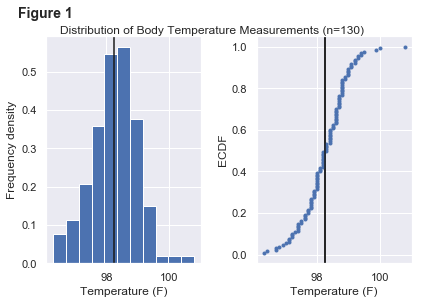

In [8]:
# (See text above for discussion)
# plot histogram of body temps
f, axes = plt.subplots(1, 2)
axes[0].hist(df.temperature, bins=int(np.floor(np.sqrt(len(df.temperature)))), density=True)
_ = plt.axvline(x=np.mean(df.temperature), color='k')
axes[0].axvline(x=np.mean(df.temperature), color='k')
#axes[0].axvline(x=98.6, color='r')
axes[0].set_xlabel('Temperature (F)')
axes[0].set_ylabel('Frequency density')

# plot ECDF of body temps
x_temp, y_temp = ecdf(df.temperature)
axes[1].plot(x_temp, y_temp, marker='.', linestyle='none')
axes[1].axvline(x=np.mean(df.temperature), color='k')
#axes[1].axvline(x=98.6, color='r')
axes[1].set_xlabel('Temperature (F)')
axes[1].set_ylabel('ECDF')

plt.text(x=0.05, y=0.95, s="Figure 1\n", fontsize=14, fontweight='bold', transform=f.transFigure)
f.suptitle('Distribution of Body Temperature Measurements (n=130)')
plt.tight_layout()

We can do a "back-of-the-envelope" test to do a quick (but not definitive) normality check (see below). This entails calculating the z-score of the minimum and minimum values in the sample. If either value is >= 3 sample standard deviations away from the sample mean, the sample may *not* be normally distrubuted. In this case, the maximum temperature (100.8 F) is 3.48 sample standard deviations from the mean, which indicates that we should take a closer look.

In [9]:
samp_min = df.temperature.min()
samp_max = df.temperature.max()
samp_mean = np.mean(df.temperature)
samp_std = np.std(df.temperature, ddof=1)  # ddof=1 because this is the sample std, not the pop std

z_min = (samp_min - samp_mean) / (samp_std)
z_max = (samp_max - samp_mean) / (samp_std)

print('Mean: ', round(samp_mean, 2), ' Sample standard deviation: ', round(samp_std, 2))
print('The min temp is', samp_min,'and is', round(z_min, 2), 'standard deviations from the mean')
print('The max temp is', samp_max, 'and is', round(z_max, 2), 'standard deviations from the mean')

Mean:  98.25  Sample standard deviation:  0.73
The min temp is 96.3 and is -2.66 standard deviations from the mean
The max temp is 100.8 and is 3.48 standard deviations from the mean


A normal probability plot can provide more evidence for the normality of our sample distribution (see Figure 2 below). Here we plot the (sorted) temperature values against the *expected* z-score of those values if they did actually come from a normal distribution. This plot should be approximately linear, and we can test that linearity by seeing if the correlation coefficient between the observed values and the expected z-scores exceeds a certain threshold. In this case, the critical value (for n > 30) is 0.960. The actual correlation coefficient is 0.992, which is > 0.960, so we can conclude that the distribution is approximately normal.

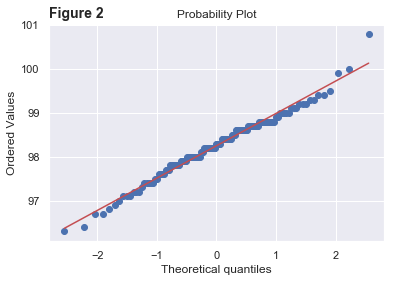

The correlation coefficient r =  0.992


In [10]:
line, r = stats.probplot(df.temperature, plot=plt, fit=True)
plt.title('Figure 2', loc='left', fontsize=14, fontweight='bold') 
plt.show()
print('The correlation coefficient r = ', round(r[2], 3))

### Q2. Is the sample size large? Are the observations independent?
The rule of thumb for the Central Limit Theorem is that for unknown (or not normal) population distributions, the distribution of the sample mean will be approximately normal if the sample size is greater than or equal to 30. There are 130 observations in this sample, which is 'large' enough to assume a normal sample mean distribution.

The original study recruited 148 subjects from inpatient vaccine trials over a period of five years. Between 1-4 temperature measures per subject were taken daily, during a 2.5 day baseline period. There's no reason to believe that any of these measurements were influenced by any others, so yes, the observations are independent.

### Q3. Is the true population mean really 98.6 degrees F?

The mean temperature from this sample (98.2) is lower than the 98.6 degrees historically considered the population mean. Using a bootstrap approach to test whether it is likely that this sample came from a population that *does* have a mean of 98.6 follows these steps

- Shift the sample values so that the sample mean is 98.6
- Take many (i.e., 10,000) replicates of the translated dataset, calculate the mean of each replicate
- Find the probability that we would have observed a mean temperature equal to or lower than our empirical mean

In this case, the probability of observing a mean less than or equal to our empirical mean was 0.0 -- out of 10,000 replications, there were *no* means that low. If we believe that our sample data is representative of the actual population, we have reason to doubt that the true population mean is 98.6 F.

In [11]:
# First translate the measured temperature values so they have a mean of 98.6
translated_temps = df.temperature + 98.6 - np.mean(df.temperature)

# Take 10,000 bootstrap replicates of the translated temperatures: bs_replicates
bs_replicates = draw_bs_reps(translated_temps, np.mean, size=10000)

# Compute fraction of replicates that are less than the observed temperatures: p
p = np.sum(bs_replicates <= np.mean(df.temperature)) / len(bs_replicates)

# Print the p-value
print('p = ',p)
print('Number of observations <= empirical mean:', np.sum(bs_replicates <= np.mean(df.temperature)))

p =  0.0
Number of observations <= empirical mean: 0


A frequentist approach would use a one-sample test because while we have observations from one sample, we only have the historic population mean (with none of those original observations). Although the t statistic is the more appropriate choice, we *could* get away with using the z statistic here because because the z-score is normally distributed when the sample size is large enough. No matter which statistic is used, as in the previous bootstrap analysis, the p-value is close to 0.0 (see below) because of the large sample size. 

In [12]:
# Calculate the test statistic
samp_mean = np.mean(df.temperature)
samp_std = np.std(df.temperature, ddof=1)  # ddof=1 because this is the sample std
n = len(df.temperature)
test_stat = (samp_mean - 98.6)/(samp_std/np.sqrt(n))

# Find the p-value from the t distribution
pval_t = 1 - stats.t.sf(test_stat, n-1) # subtract from 1 for area in right tail

# Find the p-value from the z distribution
pval_z = stats.norm.cdf(test_stat)

print('pval (t):', round(pval_t, 3), 'pval (z)', round(pval_z,3))

pval (t): 0.0 pval (z) 0.0


### Q4. What happens with sample size n=10?
This time the p-value from the t and z distributions are not equal. With small sample sizes (such as n=10), the z-score is *not* normally distributed, so is not an appropriate test. In addition, in this particular random sample of n=10, the sample standard deviation is larger, and the sample mean is not significantly different from the historical mean of 98.6 F. 

In [13]:
# Random draw of n=10
samp_n10 = np.random.choice(df.temperature, size=10)
n = 10

# Calculate the statistic to test
samp_n10_mean = np.mean(samp_n10)
samp_n10_std = np.std(samp_n10, ddof=1)  # ddof=1 to get the sample std rather than pop std
test_stat = (samp_n10_mean - 98.6)/(samp_n10_std/np.sqrt(n))

print('Mean: ', round(samp_n10_mean, 2), ' Std: ', round(samp_n10_std, 3))
print('Test statistic:', round(test_stat, 2))

pval_t = 1- stats.t.sf(test_stat, n-1) # subtract from 1 for area in right tail
pval_z = stats.norm.cdf(test_stat)
print('pval (t):', round(pval_t, 3), 'pval (z)', round(pval_z,3))

Mean:  98.32  Std:  0.644
Test statistic: -1.37
pval (t): 0.101 pval (z) 0.085


### Q5. At what temperature should we consider someone's temperature to be abnormal?

I will preface this section by saying that I'm not entirely sure this is correct. On the one hand, I get basically identical answers from the bootstrap approach and the frequentist approach (in separate sections below). On the other hand, the confidence interval seems *very* narrow, and I know that's solely due to the large sample size. The lower and upper bounds of the 99% confidence interval are marked by black lines over the ECDF plot (Figure 3 below), and in the sample data only 15 (out of 130!) observations would be considered 'normal.' That seems implausible? (NOTE: I used a 99% C.I. simply because the 95% C.I. was even narrower)

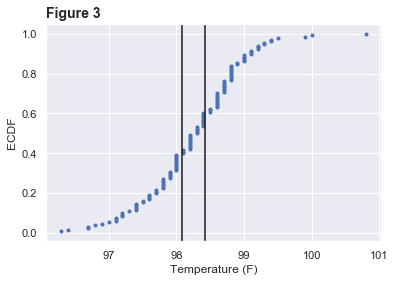

In [14]:
x, y = ecdf(df.temperature)
_ = plt.plot(x,y,marker='.', linestyle='none')
_ = plt.axvline(x=98.082, color='k')
_ = plt.axvline(x=98.416, color='k')
_ = plt.xlabel('Temperature (F)')
_ = plt.ylabel('ECDF')
_ = plt.title('Figure 3', loc='left', fontsize=14, fontweight='bold') 

The bootstrapping procedure follows these steps (see below):

- Draw a random sample (n=130 with replacement) from the original sample
- Calculate and store the margin of error (for a 99% confidence interval) from that single random sample
- Repeat for many (10,000) random samples
- The mean of the bootstrap replicates is the mean margin of error

The 99% confidence interval is 98.25° ± 0.17°, so a temperature lower than 98.08° or higher than 98.42° could be considered abnormal

In [21]:
# function to calculate margin of error (for 99% confidence interval)
def margin_of_error(bs_sample):
    "Calculate margin of error (MoE) from a single bootstrap replicate sample."""
    bs_std = np.std(bs_sample, ddof=1)
    n = len(bs_sample)
    t_val = stats.t.ppf(1-0.025, n-1)
    MoE = t_val * (bs_std/np.sqrt(n))
    return MoE

# Get many (10,000) bootstrap replicates of the margin of error of our sample dataset
bs_replicates = draw_bs_reps(df.temperature, margin_of_error, size=10000)

# Print MoE and C.I.
print('Mean MoE:', round(np.mean(bs_replicates), 3))
print('Lower bound:', round(np.mean(df.temperature) - np.mean(bs_replicates), 3), \
      ' Upper bound:', round(np.mean(df.temperature) + np.mean(bs_replicates), 3))

Mean MoE: 0.126
Lower bound: 98.123  Upper bound: 98.376


The frequentist approach yields the same values for a 99% confidence interval and related margin of error (see below).
The 99% confidence interval is 98.25° ± 0.17°, so a temperature lower than 98.08° or higher than 98.42° could be considered abnormal

In [22]:
# lower bound: samp_mean - t(0.025) * (samp_std / sqrt(n)), (n-1) degrees of freedom
# upper bound: samp_mean + t(0.025) * (samp_std / sqrt(n)), (n-1) degrees of freedom
samp_mean = np.mean(df.temperature)
samp_std = np.std(df.temperature, ddof=1)
n = len(df.temperature)

t_val = stats.t.ppf(1-0.025, n-1)
MoE = t_val * (samp_std/np.sqrt(n))

print('Mean: ', round(samp_mean, 3), ' Std:', round(samp_std, 3))
print('t-val: ', round(t_val, 2))
print('Margin of Error: ', round(MoE, 3))
print('Lower bound: ', round(samp_mean - MoE, 3), \
      ' Upper bound: ', round(samp_mean + MoE, 3))


Mean:  98.249  Std: 0.733
t-val:  1.98
Margin of Error:  0.127
Lower bound:  98.122  Upper bound:  98.376


### 6. Is there a significant difference between male and female body temperature?

First let's look at the distrubution of the two temperature samples. Male temperatures are plotted in blue and females in orange (see Figure 4, below). The solid lines mark the mean for each sample. It appears that the female temperatures (mean=98.4) are higher than the male temperatures (mean=98.1).

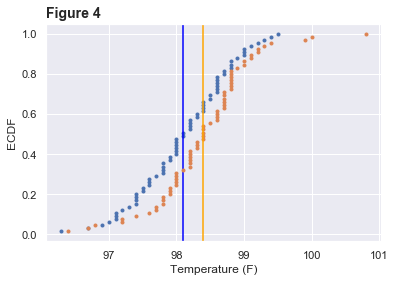

In [18]:
x_male, y_male = ecdf(df[df.gender=='M'].temperature)
x_female, y_female = ecdf(df[df.gender=='F'].temperature)
_ = plt.plot(x_male, y_male, marker='.', linestyle='none')
_ = plt.axvline(np.mean(df[df.gender=='M'].temperature), color='blue')
_ = plt.plot(x_female, y_female, marker='.', linestyle='none')
_ = plt.axvline(np.mean(df[df.gender=='F'].temperature), color='orange')
_ = plt.xlabel('Temperature (F)')
_ = plt.ylabel('ECDF')
_ = plt.title('Figure 4', loc='left', fontsize=14, fontweight='bold') 

With a bootstrapping approach, we first shift both samples so that their means are equal. Then after getting many bootstrap replicates of the mean for each sample, we find the probability that the difference between female and male temperature in the bootstrapped distribution is greater than or equal to the difference that we actually observed in the original data. In this case, there is only a 0.010 chance of observing a difference that great, so we can conclude that there is likely a difference between female and male body temperatures.

In [19]:
# Find the empirical difference of the means
empirical_diff_means = np.mean(df[df.gender=='F'].temperature) - np.mean(df[df.gender=='M'].temperature)

# Shift both samples so that they have the same mean
male_shifted = df[df.gender=='M'].temperature - np.mean(df[df.gender=='M'].temperature) + np.mean(df.temperature)
female_shifted = df[df.gender=='F'].temperature - np.mean(df[df.gender=='F'].temperature) + np.mean(df.temperature)

# Compute 10,000 bootstrap replicates from the shifted arrays
bs_replicates_male = draw_bs_reps(male_shifted, np.mean, size=10000)
bs_replicates_female = draw_bs_reps(female_shifted, np.mean, size=10000)

# Get replicates of difference of means
bs_replicates = bs_replicates_female - bs_replicates_male

# Compute and print p-value: p
p = sum(bs_replicates >= empirical_diff_means) / 10000
print('p-value = ',p)

p-value =  0.0117


If using a frequentist statistics approach, we would perform a two sample test with the following hypotheses:
- H0: mean male temp = mean female temp
- H1: mean male temp != mean female temp

We calculate the t statistic (see below) and compare it to the critical values for p = 0.05. In this case, t = 2.29 which is greater than the critical value 2.00, so we can reject the null hypothesis, H0.

In [20]:
male_n = len(df[df.gender=='M'].temperature)
male_mean = np.mean(df[df.gender=='M'].temperature)
male_std = np.std(df[df.gender=='M'].temperature, ddof=1)

female_n = len(df[df.gender=='F'].temperature)
female_mean = np.mean(df[df.gender=='F'].temperature)
female_std = np.std(df[df.gender=='F'].temperature, ddof=1)

# Calculate test statistic t0
t0 = (female_mean - male_mean) / np.sqrt((female_std**2/female_n) + (male_std**2/male_n))
print('t0 = ',t0)

# Find critical values of t(0.025), which gives p = 0.05 (two-tailed)
t_val = stats.t.ppf(1-0.025, female_n-1)
print('Critical values of t:', -1*t_val,', ', t_val)

t0 =  2.285434538165274
Critical values of t: -1.9977296536259734 ,  1.9977296536259734


### Discussion
If the dataset provided here can be considered representative of the larger population, then it is reasonable to conclude that the traditionally-used value of 98.6 for normal body temperature may not be correct, and that the normal temperature may actually be a few tenths of a degree lower. It also appears that women have a statistically significant higher body temperature than men.

This sex-based difference might point to a partial explanation of why the traditional value is higher. Women's body temperature rises slightly during pregnancy, and it is possible that Wunderlich's initial observations included some from pregnant women. In contrast, the data presented here were collected from volunteer subjects in vaccine trials; while the original article does not specify, it is unlikely that pregnant women were included in those trials. However it also seems unlikely that Wunderlich's data would contain *so* many more pregnant women than men that it would push the mean to the value that he obtained.

An alternative explanation for the difference between studies is an instrumentation difference: the thermometer used by Wunderlich in the mid-1800's was certainly not the same as the digital electronic thermometer used by Mackowiak and colleagues in 1992. Since there is no way to compare the two thermometers, we can't really know that the measures are equivalent. 